In [1]:
#further code and graphs available at: https://github.com/icecodesred/Data-Analysis-3/tree/main/Assignment_3
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

#the final attempt at forecasting is going to be done with facebook's prophet to handle multiple seasonalities.
df = pd.read_csv("data.csv", parse_dates=["ts"])
df = df.rename(columns={"ts": "ds", "v1": "y", "v2": "v2_exog"})

C:\Users\Icy\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.add_seasonality(name="daily", period=1, fourier_order=10)
model.add_regressor("v2_exog")  #v2 added as an external regressor
model.fit(df)

23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing


In [3]:
#cross-validation
def prophet_cross_validation(df, folds=5, holdout_size=30*24): #5 fold cross validation
    errors = []
    n = len(df)
    train_size = int(n * 0.7)  

    for i in range(folds):
        train_end = train_size + (i * holdout_size) 
        if train_end + holdout_size > n:
            break 

        train, test = df.iloc[:train_end], df.iloc[train_end:train_end+holdout_size]

        
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.add_seasonality(name="daily", period=1, fourier_order=10)  #high fourier number since daily data is volatile
        model.add_regressor("v2_exog") 
        model.fit(train)

        future_test = model.make_future_dataframe(periods=len(test), freq="H")

        future_test = future_test.iloc[-len(test):].copy()  
        future_test["v2_exog"] = test["v2_exog"].values 

        forecast_test = model.predict(future_test)

        test_forecast = forecast_test.iloc[-len(test):]

        actuals = test["y"].values
        predictions = test_forecast["yhat"].values

        mae = mean_absolute_error(actuals, predictions)
        rmse = np.sqrt(mean_squared_error(actuals, predictions))  
        r2 = r2_score(actuals, predictions)

        errors.append({"Fold": i+1, "MAE": mae, "RMSE": rmse, "R2": r2})

    return pd.DataFrame(errors)

In [4]:
cv_results = prophet_cross_validation(df, folds=5, holdout_size=30*24)
print(cv_results)
print(cv_results.mean())

23:41:47 - cmdstanpy - INFO - Chain [1] start processing
23:41:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Icy\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
23:41:54 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Icy\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
23:42:01 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Icy\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
23:42:08 - cmdstanpy - INFO - Chain [1] start processing
23:42:15 - cmdstanpy - INFO 

   Fold       MAE      RMSE        R2
0     1  0.226814  0.314107  0.884896
1     2  0.210677  0.294489  0.937346
2     3  0.266296  0.428533  0.903023
3     4  0.297561  0.429192  0.911501
4     5  0.320152  0.433744  0.897858
Fold    3.000000
MAE     0.264300
RMSE    0.380013
R2      0.906925
dtype: float64


23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Icy\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


                       ds      yhat  yhat_lower  yhat_upper
24592 2024-11-01 00:00:00  0.590732   -0.428294    1.643422
24593 2024-11-01 01:00:00  0.422029   -0.592394    1.476473
24594 2024-11-01 02:00:00  0.320097   -0.662582    1.307669
24595 2024-11-01 03:00:00  0.241933   -0.810776    1.318356
24596 2024-11-01 04:00:00  0.186230   -0.836453    1.222816
...                   ...       ...         ...         ...
25307 2024-11-30 19:00:00  0.787223   -0.324899    1.848753
25308 2024-11-30 20:00:00  0.772057   -0.192530    1.813592
25309 2024-11-30 21:00:00  0.783579   -0.302589    1.806142
25310 2024-11-30 22:00:00  0.720816   -0.387887    1.711702
25311 2024-11-30 23:00:00  0.549864   -0.503444    1.648545

[720 rows x 4 columns]


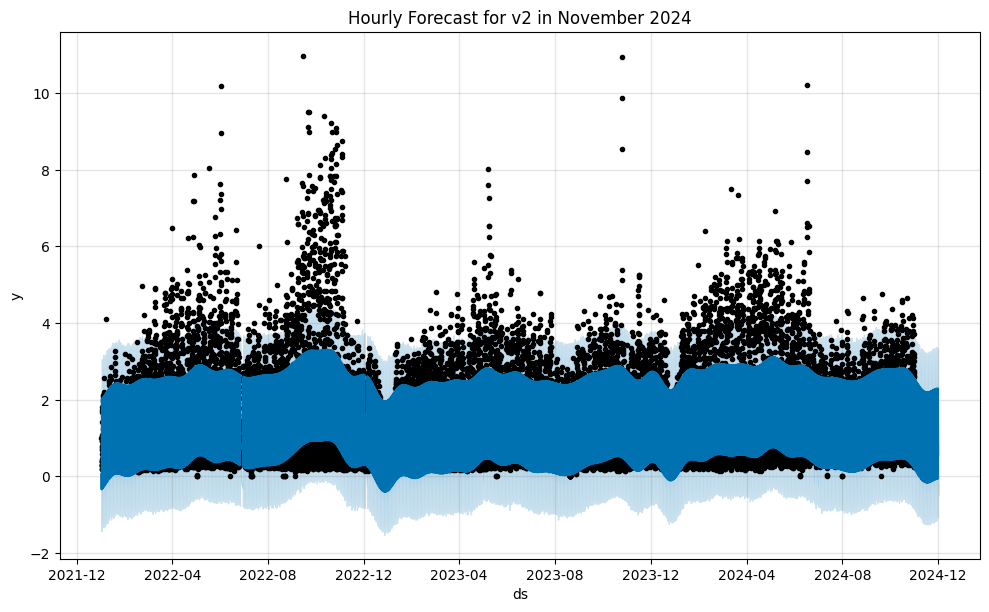

In [5]:
#we need to do a prediction of v2 
df_v2 = df.rename(columns={"ts": "ds", "v2": "y"})
model_v2 = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_v2.add_seasonality(name="daily_custom", period=1, fourier_order=5)
model_v2.fit(df_v2[['ds', 'y']])

h = 30 * 24  # 720 hours

future_v2 = model_v2.make_future_dataframe(periods=h, freq='H')

forecast_v2 = model_v2.predict(future_v2)
last_date = df_v2['ds'].max()
forecast_november_v2 = forecast_v2[forecast_v2['ds'] > last_date]

print(forecast_november_v2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

model_v2.plot(forecast_v2)
plt.title("Hourly Forecast for v2 in November 2024")
plt.show()

                       ds      yhat  yhat_lower  yhat_upper
24592 2024-11-01 00:00:00  2.088509    1.614657    2.597489
24593 2024-11-01 01:00:00  1.450196    0.920305    2.008216
24594 2024-11-01 02:00:00  1.132337    0.596941    1.647459
24595 2024-11-01 03:00:00  0.850933    0.314884    1.382940
24596 2024-11-01 04:00:00  0.594285    0.091774    1.140798
...                   ...       ...         ...         ...
25307 2024-11-30 19:00:00  2.711686    2.168250    3.249119
25308 2024-11-30 20:00:00  2.583908    2.055824    3.131215
25309 2024-11-30 21:00:00  2.580926    2.033975    3.090721
25310 2024-11-30 22:00:00  2.280112    1.726218    2.821195
25311 2024-11-30 23:00:00  1.548030    1.063563    2.099072

[720 rows x 4 columns]


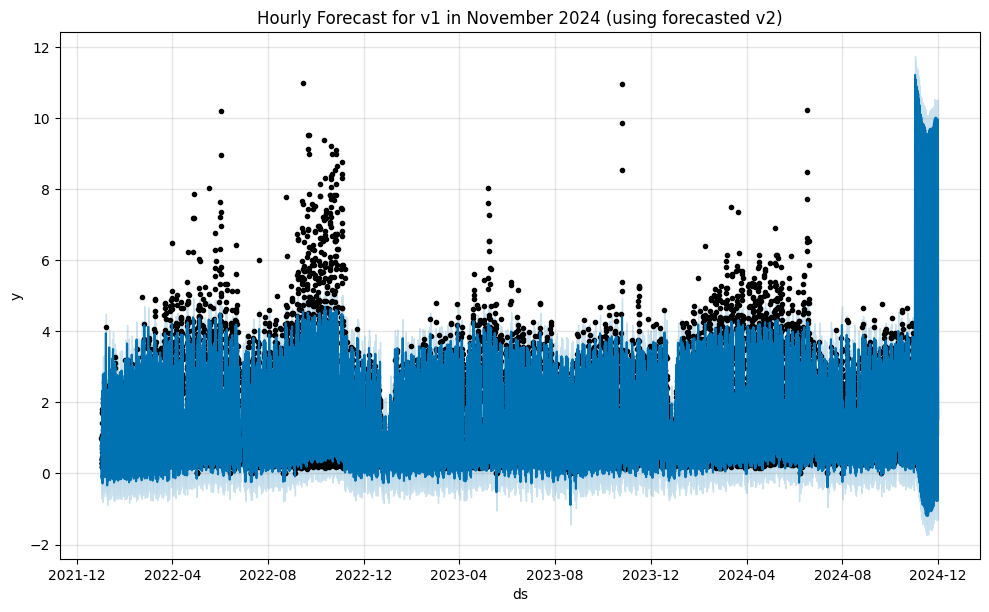

In [6]:
future_v1 = model.make_future_dataframe(periods=h, freq='h')

future_v1 = future_v1.merge(df[['ds', 'v2_exog']], on='ds', how='left')

mask = future_v1['ds'] > df['ds'].max()
if mask.sum() != len(forecast_november_v2):
    raise ValueError("Mismatch in number of forecast rows for v2!")
future_v1.loc[mask, 'v2_exog'] = forecast_november_v2['yhat'].values

if future_v1['v2_exog'].isnull().any():
    raise ValueError("There are still NaNs in v2_exog!")

forecast_v1 = model.predict(future_v1)

forecast_november_v1 = forecast_v1[forecast_v1['ds'] > df['ds'].max()]

print(forecast_november_v1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
model.plot(forecast_v1)
plt.title("Hourly Forecast for v1 in November 2024 (using forecasted v2)")
plt.show()


In [7]:
forecast_november_v1 = forecast_november_v1[['ds', 'yhat']].rename(columns={'yhat': 'v1'})
forecast_november_v2 = forecast_november_v2[['ds', 'yhat']].rename(columns={'yhat': 'v2'})

combined_forecasts = pd.merge(forecast_november_v1, forecast_november_v2, on='ds', how='inner')

combined_forecasts.to_csv("forecast_Eniko_Palko.csv", index=False)
print("Forecasts saved to forecast_Eniko_Palko.csv")

Forecasts saved to forecast_Eniko_Palko.csv
